In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
S, P = np.load("../data/dataset.npy")
molecules = np.load("../data/molecules.npy")

In [3]:
from SCFInitialGuess.utilities.dataset import Dataset

dim = 26

ind_cut = 150
index = np.arange(200)
np.random.shuffle(index)

S_test = np.array(S)[index[150:]]
P_test = np.array(P)[index[150:]]
molecules_test = [molecules[index[i]] for i in range(150, 200)]

S_train = np.array(S)[index[:150]]
P_train = np.array(P)[index[:150]]
molecules_train = [molecules[index[i]] for i in range(150)]

dataset = Dataset(np.array(S_train), np.array(P_train), split_test=0.0)

dataset.testing = (Dataset.normalize(S_test, mean=dataset.x_mean, std=dataset.x_std)[0], P_test)

[-] 2018-04-16 21:19:25: Data set normalized. Mean value std: 0.008710623263892549


# Training different costs

In [4]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, RegularizedMSE

trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=RegularizedMSE(alpha=1e-7)
)

trainer.setup()
network_orig, sess_orig = trainer.train(
    dataset,
    convergence_threshold=1e-7
)
graph_orig = trainer.graph

[-] 2018-04-16 21:19:25: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-04-16 21:19:25: Setting up the training in the target graph ...
[-] 2018-04-16 21:19:26: network ...
[-] 2018-04-16 21:19:26: error function ...
[-] 2018-04-16 21:19:26: cost function ...
[-] 2018-04-16 21:19:27: training step
[-] 2018-04-16 21:19:28: Starting network training ...
[ ] 2018-04-16 21:19:28: Val. Cost: 5.783E-02. Error: 5.782E-02. Diff: 1.0E+10
[ ] 2018-04-16 21:19:29: Val. Cost: 1.015E-04. Error: 9.993E-05. Diff: 5.8E-02
[ ] 2018-04-16 21:19:29: Val. Cost: 3.626E-05. Error: 3.473E-05. Diff: 6.5E-05
[ ] 2018-04-16 21:19:30: Val. Cost: 2.605E-05. Error: 2.454E-05. Diff: 1.0E-05
[ ] 2018-04-16 21:19:31: Val. Cost: 2.415E-05. Error: 2.264E-05. Diff: 1.9E-06
[ ] 2018-04-16 21:19:32: Val. Cost: 2.164E-05. Error: 2.014E-05. Diff: 2.5E-06
[ ] 2018-04-16 21:19:32: Val. Cost: 1.716E-05. Error: 1.566E-05. Diff: 4.5E-06
[ ] 2018-04-16 21:19:33: Val. Cost: 1.265E-04. Error: 1.250E-04

### Check symmetry

0.0006170495


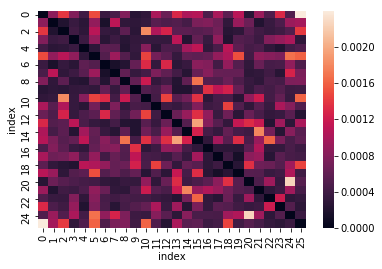

In [6]:
from SCFInitialGuess.utilities.analysis import matrix_error

with graph_orig.as_default():
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))

plt.show()

### Check idempotency

0.001858144


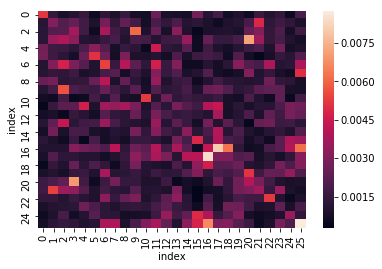

In [18]:
from SCFInitialGuess.utilities.analysis import matrix_error

def idempotency_error(network):
    p = tf.reshape(network.output_tensor, [-1, dim, dim])
    s_raw = dataset.inverse_input_transform(network.input_tensor)
    s = tf.reshape(s_raw, [-1, dim, dim])
    
    
    lhs = tf.matmul(tf.matmul(p, s), p)
    rhs = 2 * p
    return tf.reduce_mean(tf.abs(lhs - rhs), axis=0)

with graph_orig.as_default():
    
    
    """
    reshaped = tf.reshape(network_orig.output_tensor, [-1, dim, dim])
    squared = tf.matmul(reshaped, reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - squared), axis=0)
    error = sess_orig.run(diff_mean, {network_orig.input_tensor: dataset.testing[0]})
    """
    error = sess_orig.run(
        idempotency_error(network_orig),
       {network_orig.input_tensor: dataset.testing[0]}
    )
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()

## Enforce symmetry

In [9]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class SymmetryPenalty(MSE):
    def __init__(self, coupling=1e-4):
        """alpha: coupling parameter"""
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(SymmetryPenalty, self).function(network, y_placeholder)

        penalty = self.symmetry_measure(network.output_tensor) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def symmetry_measure(self, output_tensor):
        
        reshaped = tf.reshape(output_tensor, [-1, dim, dim])
        transposed = tf.matrix_transpose(reshaped)
        return tf.reduce_mean(tf.norm(reshaped - transposed, axis=(1,2))**2 )

    
trainer_sym = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=SymmetryPenalty(coupling=5e-2)
)

trainer_sym.setup()
network_sym, sess_sym = trainer_sym.train(
    dataset,
    convergence_threshold=1e-6
)
graph_sym = trainer_sym.graph
        

[-] 2018-04-16 21:21:29: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-04-16 21:21:29: Setting up the training in the target graph ...
[-] 2018-04-16 21:21:29: network ...
[-] 2018-04-16 21:21:30: error function ...
[-] 2018-04-16 21:21:30: cost function ...
[-] 2018-04-16 21:21:30: training step
[-] 2018-04-16 21:21:30: Starting network training ...
[ ] 2018-04-16 21:21:30: Val. Cost: 6.318E-02. Error: 5.778E-02. Diff: 1.0E+10
[ ] 2018-04-16 21:21:31: Val. Cost: 4.977E-04. Error: 2.658E-04. Diff: 5.8E-02
[ ] 2018-04-16 21:21:32: Val. Cost: 2.424E-04. Error: 1.422E-04. Diff: 1.2E-04
[ ] 2018-04-16 21:21:32: Val. Cost: 1.647E-04. Error: 1.176E-04. Diff: 2.5E-05
[ ] 2018-04-16 21:21:33: Val. Cost: 5.181E-04. Error: 1.344E-04. Diff: 1.7E-05
[ ] 2018-04-16 21:21:34: Val. Cost: 1.420E-04. Error: 8.849E-05. Diff: 4.6E-05
[ ] 2018-04-16 21:21:35: Val. Cost: 9.996E-05. Error: 4.821E-05. Diff: 4.0E-05
[ ] 2018-04-16 21:21:36: Val. Cost: 1.986E-04. Error: 3.632E-05

0.0007955005


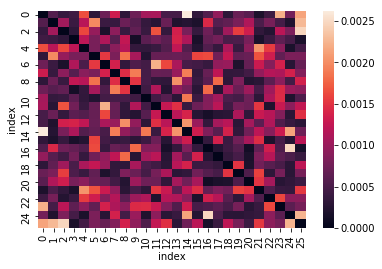

In [10]:
with graph_sym.as_default():
    reshaped = tf.reshape(network_sym.output_tensor, [-1, dim, dim])
    transposed = tf.matrix_transpose(reshaped)
    diff_mean = tf.reduce_mean(tf.abs(reshaped - transposed), axis=0)
    error = sess_sym.run(diff_mean, {network_sym.input_tensor: dataset.testing[0]})
    matrix_error(error)
    print(np.mean(error))

plt.show()

## Enforce idempotency

In [11]:
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.training import Trainer, MSE

class IdempotencyPenalty(MSE):
    def __init__(self, coupling=1e-4):
        
        self.coupling = coupling
        
    def function(self, network, y_placeholder):

        error = \
            super(IdempotencyPenalty, self).function(network, y_placeholder)

        penalty = self.idempotency_error(network) * self.coupling

        cost = error + penalty

        tf.summary.scalar("symmetry_penalty", penalty)
        tf.summary.scalar("total_loss", cost)

        return cost
    
    def idempotency_error(self, network):
        p = tf.reshape(network.output_tensor, [-1, dim, dim])
        s_raw = dataset.inverse_input_transform(network.input_tensor)
        s = tf.reshape(s_raw, [-1, dim, dim])
        

        lhs = tf.matmul(tf.matmul(p, s), p)
        rhs = 2 * p
        return tf.reduce_mean(tf.norm(tf.abs(lhs - rhs), axis=(1,2)) **2 )

try:
    del graph_idem
except:
    pass
    
trainer = Trainer(
    EluTrNNN([dim**2, 200, 100, dim**2]),
    cost_function=IdempotencyPenalty(coupling=1e-5)
)

trainer.setup()
network_idem, sess_idem = trainer.train(
    dataset,
    convergence_threshold=3e-6,
    summary_save_path="log2/idem"
)
graph_idem = trainer.graph

[-] 2018-04-16 21:26:41: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-04-16 21:26:41: Setting up the training in the target graph ...
[-] 2018-04-16 21:26:41: network ...
[-] 2018-04-16 21:26:41: error function ...
[-] 2018-04-16 21:26:41: cost function ...
[-] 2018-04-16 21:26:41: training step
[-] 2018-04-16 21:26:41: Starting network training ...
[ ] 2018-04-16 21:26:41: Val. Cost: 5.794E-02. Error: 5.793E-02. Diff: 1.0E+10
[ ] 2018-04-16 21:26:42: Val. Cost: 1.067E-04. Error: 1.049E-04. Diff: 5.8E-02
[ ] 2018-04-16 21:26:44: Val. Cost: 4.449E-05. Error: 4.357E-05. Diff: 6.1E-05
[ ] 2018-04-16 21:26:45: Val. Cost: 3.829E-05. Error: 3.745E-05. Diff: 6.1E-06
[ ] 2018-04-16 21:26:46: Val. Cost: 5.988E-05. Error: 5.854E-05. Diff: 2.1E-05
[ ] 2018-04-16 21:26:47: Val. Cost: 5.241E-05. Error: 5.121E-05. Diff: 7.3E-06
[ ] 2018-04-16 21:26:48: Val. Cost: 4.713E-05. Error: 4.604E-05. Diff: 5.2E-06
[ ] 2018-04-16 21:26:49: Val. Cost: 3.038E-05. Error: 2.969E-05

0.0023619917


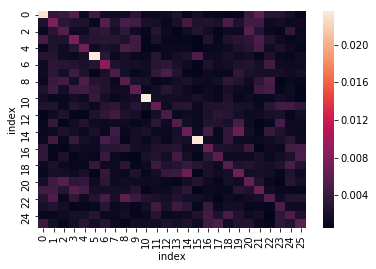

In [12]:
with graph_idem.as_default():
    error = sess_idem.run(idempotency_error(network_idem), {network_idem.input_tensor: dataset.testing[0]})
    
    matrix_error(error)
    print(np.mean(error))
    
plt.show()
    
    

# Analysis

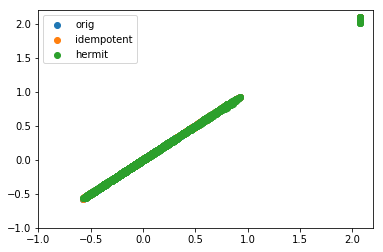

In [13]:
with graph_orig.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_orig.run(sess_orig, dataset.testing[0]),
        label="orig"
    )
    
with graph_idem.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_idem.run(sess_idem, dataset.testing[0]),
        label="idempotent"
    )
    

with graph_sym.as_default():
    plt.scatter(
        x=dataset.testing[1],
        y=network_sym.run(sess_sym, dataset.testing[0]),
        label="hermit"
    )

#lower = 1.8
lower = -1
upper = 2.2
plt.xlim([lower, upper])
plt.ylim([lower, upper])
    

plt.legend()
plt.show()

In [15]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.analysis import prediction_scatter

dim = 26

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean(np.abs(np.dot(np.dot(p, s), p) - 2 * p))

iterations = []
for i, (molecule, p) in enumerate(zip(molecules_test, P_test)):
    
    mol = molecule.get_pyscf_molecule()
    
    
    print("Calculating: " + str(i + 1) + "/" + str(len(molecules_test)))
    
    # nn guess
    s_raw = hf.get_ovlp(mol).reshape(1, dim**2)
    s = Dataset.normalize(s_raw, mean=dataset.x_mean, std=dataset.x_std)[0]
    
    with graph_orig.as_default():
        P_orig = network_orig.run(sess_orig, s).reshape(dim, dim).astype('float64')
        
        print("idemp orig:    " + str(idemp_error(p, s_raw)))
        print("Idemp orig NN: " + str(idemp_error(P_orig, s_raw)))
        
    with graph_idem.as_default():
        P_idem = network_idem.run(sess_idem, s).reshape(dim, dim).astype('float64')
        print("Idemp idem NN: " + str(idemp_error(P_idem, s_raw)))
    
    with graph_sym.as_default():
        P_sym = network_sym.run(sess_sym, s).reshape(dim, dim).astype('float64')
        print("Idemp sym NN: " + str(idemp_error(P_sym, s_raw)))
    
    
    # P_actual wi noise
    p_noise = p.reshape(dim, dim) + np.random.randn(dim, dim) * 5e-3
    
    
    iterations_molecule = []
    for guess in [p_noise, P_orig, P_idem, P_sym]:
        
        mf = hf.RHF(mol)
        mf.diis = None
        mf.verbose = 1
        mf.kernel(dm0=guess)
        iterations_molecule.append(mf.iterations)
    
    iterations.append(iterations_molecule)

iterations = np.array(iterations)

Warn: Ipython shell catchs sys.args


Calculating: 1/50
idemp orig:    2.6847075141362027e-16
Idemp orig NN: 0.0020659518226290195
Idemp idem NN: 0.002042464204473053
Idemp sym NN: 0.0022138676067214947


Warn: Ipython shell catchs sys.args


Calculating: 2/50
idemp orig:    2.1720089964246496e-16
Idemp orig NN: 0.0018508757628943086
Idemp idem NN: 0.0021382264215324314
Idemp sym NN: 0.0017240710728332958


Warn: Ipython shell catchs sys.args


Calculating: 3/50
idemp orig:    3.694108557891729e-16
Idemp orig NN: 0.001984802889473933
Idemp idem NN: 0.0033482571793774156
Idemp sym NN: 0.002211923849345017


Warn: Ipython shell catchs sys.args


Calculating: 4/50
idemp orig:    3.728944968080296e-16
Idemp orig NN: 0.0017581599088101637
Idemp idem NN: 0.0026064907169236727
Idemp sym NN: 0.0022924104722171802


Warn: Ipython shell catchs sys.args


Calculating: 5/50
idemp orig:    2.538079144245793e-16
Idemp orig NN: 0.001972236083262755
Idemp idem NN: 0.003876495252674516
Idemp sym NN: 0.0034798923225844414


Warn: Ipython shell catchs sys.args


Calculating: 6/50
idemp orig:    2.526365881472292e-16
Idemp orig NN: 0.0016534477163554157
Idemp idem NN: 0.0020483078555332086
Idemp sym NN: 0.0030877457164396028


Warn: Ipython shell catchs sys.args


Calculating: 7/50
idemp orig:    2.702647972680805e-16
Idemp orig NN: 0.0023078256472905284
Idemp idem NN: 0.004706100621090544
Idemp sym NN: 0.006486678820751775


Warn: Ipython shell catchs sys.args


Calculating: 8/50
idemp orig:    2.546859467728914e-16
Idemp orig NN: 0.0020018951210676542
Idemp idem NN: 0.0017888718591302106
Idemp sym NN: 0.0028806085870758803


Warn: Ipython shell catchs sys.args


Calculating: 9/50
idemp orig:    2.552851849928543e-16
Idemp orig NN: 0.0018307322388086342
Idemp idem NN: 0.0019170986355833924
Idemp sym NN: 0.0028360030784946614


Warn: Ipython shell catchs sys.args


Calculating: 10/50
idemp orig:    2.6059384620708267e-16
Idemp orig NN: 0.0018204706607089962
Idemp idem NN: 0.0023146019359134985
Idemp sym NN: 0.0020241748473953437


Warn: Ipython shell catchs sys.args


Calculating: 11/50
idemp orig:    3.172049173346283e-16
Idemp orig NN: 0.001475214206400184
Idemp idem NN: 0.002173095864901286
Idemp sym NN: 0.002162247362016796


Warn: Ipython shell catchs sys.args


Calculating: 12/50
idemp orig:    2.4143562493390927e-16
Idemp orig NN: 0.0019321558471019672
Idemp idem NN: 0.0025198620667999188
Idemp sym NN: 0.0028431372009336837


Warn: Ipython shell catchs sys.args


Calculating: 13/50
idemp orig:    3.213269705942511e-16
Idemp orig NN: 0.0017531130518062478
Idemp idem NN: 0.0016510671031462127
Idemp sym NN: 0.0016190718299472634


Warn: Ipython shell catchs sys.args


Calculating: 14/50
idemp orig:    2.799636954043085e-16
Idemp orig NN: 0.0017763757336620408
Idemp idem NN: 0.001905383579853588
Idemp sym NN: 0.0021578889065600863


Warn: Ipython shell catchs sys.args


Calculating: 15/50
idemp orig:    3.3984830328355764e-16
Idemp orig NN: 0.0018870028931473463
Idemp idem NN: 0.001862996104783364
Idemp sym NN: 0.0023483212968218197


Warn: Ipython shell catchs sys.args


Calculating: 16/50
idemp orig:    3.7877685494104215e-16
Idemp orig NN: 0.0022248059434789684
Idemp idem NN: 0.001617448571625891
Idemp sym NN: 0.002010069906964807


Warn: Ipython shell catchs sys.args


Calculating: 17/50
idemp orig:    3.118790147396984e-16
Idemp orig NN: 0.0014809837107047361
Idemp idem NN: 0.0029126834848420746
Idemp sym NN: 0.0020078700509074347


Warn: Ipython shell catchs sys.args


Calculating: 18/50
idemp orig:    3.0017656792536973e-16
Idemp orig NN: 0.002065383699414872
Idemp idem NN: 0.0018499294294706742
Idemp sym NN: 0.003415347139184959


Warn: Ipython shell catchs sys.args


Calculating: 19/50
idemp orig:    2.783371916644093e-16
Idemp orig NN: 0.0016281819507892481
Idemp idem NN: 0.0019169062045680059
Idemp sym NN: 0.0021438757031997063


Warn: Ipython shell catchs sys.args


Calculating: 20/50
idemp orig:    3.3135556001610266e-16
Idemp orig NN: 0.0016849112945857233
Idemp idem NN: 0.002681478803845666
Idemp sym NN: 0.0034247642103996763


Warn: Ipython shell catchs sys.args


Calculating: 21/50
idemp orig:    2.699375518527425e-16
Idemp orig NN: 0.0017806024534569094
Idemp idem NN: 0.0019085882579718736
Idemp sym NN: 0.0029745985358418043


Warn: Ipython shell catchs sys.args


Calculating: 22/50
idemp orig:    3.233045168644798e-16
Idemp orig NN: 0.001901126345923981
Idemp idem NN: 0.0018841422560289297
Idemp sym NN: 0.0027825036101683603


Warn: Ipython shell catchs sys.args


Calculating: 23/50
idemp orig:    2.364288883631282e-16
Idemp orig NN: 0.0019054869808840574
Idemp idem NN: 0.002138712873682479
Idemp sym NN: 0.002704555770292282


Warn: Ipython shell catchs sys.args


Calculating: 24/50
idemp orig:    2.3799228063041305e-16
Idemp orig NN: 0.0019400816454571107
Idemp idem NN: 0.0022028533933472396
Idemp sym NN: 0.004498877445215603


Warn: Ipython shell catchs sys.args


Calculating: 25/50
idemp orig:    2.6576433579829387e-16
Idemp orig NN: 0.0012749635026851915
Idemp idem NN: 0.0020494898571816766
Idemp sym NN: 0.0018616803464277987


Warn: Ipython shell catchs sys.args


Calculating: 26/50
idemp orig:    2.719501021354187e-16
Idemp orig NN: 0.0014925129445959814
Idemp idem NN: 0.0019037472653219297
Idemp sym NN: 0.002875071514115063


Warn: Ipython shell catchs sys.args


Calculating: 27/50
idemp orig:    2.3084508678989107e-16
Idemp orig NN: 0.0018167699388432622
Idemp idem NN: 0.0024382771210529224
Idemp sym NN: 0.0019013978786380386


Warn: Ipython shell catchs sys.args


Calculating: 28/50
idemp orig:    2.814664220692646e-16
Idemp orig NN: 0.0019922669261559565
Idemp idem NN: 0.002182941803821801
Idemp sym NN: 0.0018204163879684675


Warn: Ipython shell catchs sys.args


Calculating: 29/50
idemp orig:    3.096541548969885e-16
Idemp orig NN: 0.002332790143599008
Idemp idem NN: 0.0021401385426559265
Idemp sym NN: 0.0040925314429562975


Warn: Ipython shell catchs sys.args


Calculating: 30/50
idemp orig:    3.3071389998036727e-16
Idemp orig NN: 0.0018488101911914047
Idemp idem NN: 0.002537870538229977
Idemp sym NN: 0.004269583668219402


Warn: Ipython shell catchs sys.args


Calculating: 31/50
idemp orig:    2.561851048730046e-16
Idemp orig NN: 0.0019401899723825056
Idemp idem NN: 0.0018045016423014755
Idemp sym NN: 0.00284370150842186


Warn: Ipython shell catchs sys.args


Calculating: 32/50
idemp orig:    2.6395928352754856e-16
Idemp orig NN: 0.002133153349701623
Idemp idem NN: 0.002735818108718772
Idemp sym NN: 0.003764012330811765


Warn: Ipython shell catchs sys.args


Calculating: 33/50
idemp orig:    2.278736350665717e-16
Idemp orig NN: 0.002029998497810268
Idemp idem NN: 0.0017150961006980098
Idemp sym NN: 0.002057269024840114


Warn: Ipython shell catchs sys.args


Calculating: 34/50
idemp orig:    3.0907781162674787e-16
Idemp orig NN: 0.0017722494786842986
Idemp idem NN: 0.0017894841310006817
Idemp sym NN: 0.0035830233636290724


Warn: Ipython shell catchs sys.args


Calculating: 35/50
idemp orig:    3.253291361136471e-16
Idemp orig NN: 0.0014481243999475834
Idemp idem NN: 0.0019432823763683626
Idemp sym NN: 0.0019218743216508683


Warn: Ipython shell catchs sys.args


Calculating: 36/50
idemp orig:    3.0611354464739235e-16
Idemp orig NN: 0.001831753100886887
Idemp idem NN: 0.0018991585716227606
Idemp sym NN: 0.0033793346711833826


Warn: Ipython shell catchs sys.args


Calculating: 37/50
idemp orig:    2.7181267229273403e-16
Idemp orig NN: 0.001962233761520797
Idemp idem NN: 0.002332708653214084
Idemp sym NN: 0.0023910161544772293


Warn: Ipython shell catchs sys.args


Calculating: 38/50
idemp orig:    2.7028866956351113e-16
Idemp orig NN: 0.0014129044108334321
Idemp idem NN: 0.0019683872598500007
Idemp sym NN: 0.0017050953852037589


Warn: Ipython shell catchs sys.args


Calculating: 39/50
idemp orig:    3.0995285680561285e-16
Idemp orig NN: 0.001647088440071489
Idemp idem NN: 0.001710628312101893
Idemp sym NN: 0.0022589690464526993


Warn: Ipython shell catchs sys.args


Calculating: 40/50
idemp orig:    3.870217934571471e-16
Idemp orig NN: 0.0020847487105505724
Idemp idem NN: 0.004486375965212463
Idemp sym NN: 0.0030025931508632833


Warn: Ipython shell catchs sys.args


Calculating: 41/50
idemp orig:    2.961641778662554e-16
Idemp orig NN: 0.0018251578279926417
Idemp idem NN: 0.002860604128460901
Idemp sym NN: 0.001806986386687459


Warn: Ipython shell catchs sys.args


Calculating: 42/50
idemp orig:    3.218550379985275e-16
Idemp orig NN: 0.0019092840708924063
Idemp idem NN: 0.0016438893211824452
Idemp sym NN: 0.0021700660433602533


Warn: Ipython shell catchs sys.args


Calculating: 43/50
idemp orig:    2.826555961828583e-16
Idemp orig NN: 0.001873972261197858
Idemp idem NN: 0.0038013007136851163
Idemp sym NN: 0.0026945123873778364


Warn: Ipython shell catchs sys.args


Calculating: 44/50
idemp orig:    3.8016362329672204e-16
Idemp orig NN: 0.0018905107456403322
Idemp idem NN: 0.0017479681748072294
Idemp sym NN: 0.0023239314921774234


Warn: Ipython shell catchs sys.args


Calculating: 45/50
idemp orig:    2.397297707465489e-16
Idemp orig NN: 0.001474104856571664
Idemp idem NN: 0.0025370359275976016
Idemp sym NN: 0.002214851295648838


Warn: Ipython shell catchs sys.args


Calculating: 46/50
idemp orig:    2.86904754504862e-16
Idemp orig NN: 0.0019228495214044879
Idemp idem NN: 0.0035230863667529808
Idemp sym NN: 0.003657960333394533


Warn: Ipython shell catchs sys.args


Calculating: 47/50
idemp orig:    3.400889608811633e-16
Idemp orig NN: 0.0017093275802487447
Idemp idem NN: 0.002106358137116761
Idemp sym NN: 0.0018214624496087416


Warn: Ipython shell catchs sys.args


Calculating: 48/50
idemp orig:    3.1478414729166825e-16
Idemp orig NN: 0.0025677153211251533
Idemp idem NN: 0.003516456578019002
Idemp sym NN: 0.002580666923760315


Warn: Ipython shell catchs sys.args


Calculating: 49/50
idemp orig:    2.7026473712372924e-16
Idemp orig NN: 0.0020023470442454045
Idemp idem NN: 0.0019275418680105192
Idemp sym NN: 0.00424309100059588


Warn: Ipython shell catchs sys.args


Calculating: 50/50
idemp orig:    2.629236779909008e-16
Idemp orig NN: 0.002029553174567202
Idemp idem NN: 0.0027854092670622364
Idemp sym NN: 0.002314582863181394


In [16]:
print("noise", "orig", "idem", "sym")
print(np.mean(iterations,0))

noise orig idem sym
[12.32 11.4  12.86 13.68]


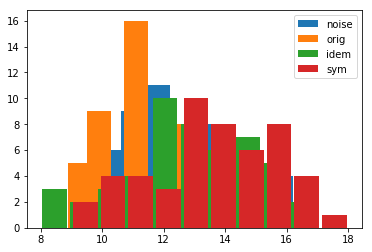

In [17]:

bins = 20 # todo hier kann man auch ein array angeben

for i, name in enumerate(['noise', 'orig', 'idem', 'sym']):
    
    hist, bins = np.histogram(iterations[:,i])
    center = (bins[:-1] + bins[1:]) / 2
    #axes[i].bar(center, hist, label=name)
    plt.bar(center, hist, label=name)
    
plt.legend()
plt.show()